In [1]:
import os
import sys
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision

In [ ]:
from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files
from models import SNN, SpikingConv2DLayer, SpikingDenseLayer#, ReadoutLayer
# from models import SpikingConv3DLayer, ReadoutLayer, SurrogateHeaviside

from optim import RAdam

In [2]:
from data_augmentor import data_augment, batchify
from time_expector import TimeExpector
from notify import notify
from sklearn.model_selection import train_test_split
te = TimeExpector()

In [3]:
batch_size = 8
nb_epochs = 2

In [4]:
# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")
    
dtype = torch.float

using cuda...


In [5]:
CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation
    )

In [6]:
class SurrogateHeaviside(torch.autograd.Function):
    # Activation function with surrogate gradient
    sigma = 10.0

    @staticmethod
    def forward(ctx, input):
        output = torch.zeros_like(input)
        output[input > 0] = 1.0
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # approximation of the gradient using sigmoid function
        grad = grad_input * torch.sigmoid(SurrogateHeaviside.sigma * input) * torch.sigmoid(
            -SurrogateHeaviside.sigma * input)
        return grad


In [7]:
class ReadoutLayer(torch.nn.Module):
    def __init__(self, input_shape, output_shape, w_init_mean, w_init_std, eps=1e-8, time_reduction="mean"):

        assert time_reduction in ["mean", "max"], 'time_reduction should be "mean" or "max"'

        super(ReadoutLayer, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.eps = eps
        self.time_reduction = time_reduction

        self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
#         self.w = torch.nn.Parameter(torch.empty((10, 20)), requires_grad=True)
        if time_reduction == "max":
            self.beta = torch.nn.Parameter(torch.tensor(0.7 * np.ones((1))), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.mem_rec_hist = None

    def forward(self, x):
#         print('readout step')
#         print("~~~~~~~~~~~ readout ~~~~~~~~~~~")
        batch_size = x.shape[0]

#         print('x.shape=', x.shape)
#         print('w.shape=', self.w.shape)
        
        h = torch.einsum("abc,cd->abd", x, self.w)
        
#         print('after einsum')
        
        norm = (self.w ** 2).sum(0)

        if self.time_reduction == "max":
            nb_steps = x.shape[1]
            # membrane potential 
            mem = torch.zeros((batch_size, self.output_shape), dtype=x.dtype, device=x.device)

            # memrane potential recording
            mem_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

            for t in range(nb_steps):
                # membrane potential update
                mem = mem * self.beta + (1 - self.beta) * h[:, t, :]
                mem_rec[:, t, :] = mem

            output = torch.max(mem_rec, 1)[0] / (norm + 1e-8) - self.b

        elif self.time_reduction == "mean":

            mem_rec = h
            output = torch.mean(mem_rec, 1) / (norm + 1e-8) - self.b

#         print('almost end of readout')
            
        # save mem_rec for plotting
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()

        loss = None

        return output, loss

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / np.prod(self.input_shape)))

        if self.time_reduction == "max":
            torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)

        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):

        if self.time_reduction == "max":
            self.beta.data.clamp_(0., 1.)

In [8]:
class SpikingConv3DLayer(torch.nn.Module):
    def __init__(self, input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean, w_init_std, recurrent=False,
                 lateral_connections=True,
                 eps=1e-8, stride=(1, 1, 1), flatten_output=False):

        super(SpikingConv3DLayer, self).__init__()

        self.kernel_size = np.array(kernel_size)
        self.dilation = np.array(dilation)
        self.stride = np.array(stride)
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.lateral_connections = lateral_connections
        self.eps = eps

        self.flatten_output = flatten_output

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((out_channels, in_channels, *kernel_size)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((out_channels, out_channels)), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(out_channels), requires_grad=True)

        self.reset_parameters()
        self.clamp()

        self.spk_rec_hist = None

        self.training = True

    def forward(self, x):
        batch_size = x.shape[0]

        
        stride=tuple(self.stride)
        padding=tuple(np.ceil(((self.kernel_size - 1) * self.dilation) / 2).astype(int))
        conv_x = torch.nn.functional.conv3d(x, self.w, padding=padding,
                                            dilation=tuple(self.dilation),
                                            stride=stride)
        
        conv_x = conv_x[:, :, :, :self.output_shape[0], :self.output_shape[1]]
        nb_steps = conv_x.shape[2]

        mem = torch.zeros((batch_size, self.out_channels, *self.output_shape), dtype=x.dtype, device=x.device)
        spk = torch.zeros((batch_size, self.out_channels, *self.output_shape), dtype=x.dtype, device=x.device)

        spk_rec = torch.zeros((batch_size, self.out_channels, nb_steps, *self.output_shape), dtype=x.dtype,
                              device=x.device)

        if self.lateral_connections:
            d = torch.einsum("abcde, fbcde -> af", self.w, self.w)
        b = self.b.unsqueeze(1).unsqueeze(1).repeat((1, *self.output_shape))

        norm = (self.w ** 2).sum((1, 2, 3, 4))

        for t in range(nb_steps):
            if self.lateral_connections:
                rst = torch.einsum("abcd,be ->aecd", spk, d)
            else:
                rst = torch.einsum("abcd,b,b->abcd", spk, self.b, norm)

            input_ = conv_x[:, :, t, :, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("abcd,be->aecd", spk, self.v)

            mem = (mem - rst) * self.beta + input_ * (1. - self.beta)
            mthr = torch.einsum("abcd,b->abcd", mem, 1. / (norm + self.eps)) - b

            spk = self.spike_fn(mthr)

            spk_rec[:, :, t, :, :] = spk

        self.spk_rec_hist = spk_rec.detach().cpu().numpy()

        loss = 0.5 * (spk_rec ** 2).mean()

        if self.flatten_output:
            output = torch.transpose(spk_rec, 1, 2).contiguous()
            output = output.view(batch_size, nb_steps, self.out_channels * np.prod(self.output_shape))
        else:
            output = spk_rec

        return output, loss

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean,
                              std=self.w_init_std * np.sqrt(1. / (self.in_channels * np.prod(self.kernel_size))))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean,
                                  std=self.w_init_std * np.sqrt(1. / self.out_channels))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)

In [9]:
spike_fn = SurrogateHeaviside.apply
layers = []

w_init_std = 0.15
w_init_mean = 0.1

in_channels = 1
out_channels = 16
kernel_size = (1,3,3)
dilation = (1,1,1)
input_shape = (64, 64)

# kernel_size = (3,3)
# dilation = (1,1)
# input_shape = 64*64

output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv3DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=True,
                               lateral_connections=True, flatten_output=True
                            ))


# in_channels = out_channels
# out_channels = 32
# kernel_size = (1,3,3)
# # dilation = (1,1,1)
# # input_shape = output_shape
# # output_shape = input_shape # padding mode is "same"
# layers.append(SpikingConv3DLayer(input_shape, output_shape,
#                  in_channels, out_channels, kernel_size, dilation,
#                  spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
#                               lateral_connections=True,
#                                 flatten_output=True))

# in_channels = out_channels
# out_channels = 64
# kernel_size = (4,3)
# dilation = (16,9)
# input_shape = output_shape
# output_shape = input_shape # padding mode is "same"
# layers.append(SpikingConv2DLayer(input_shape, output_shape,
#                  in_channels, out_channels, kernel_size, dilation,
#                  spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
#                                lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = np.prod([output_shape[0], output_shape[1], out_channels])
# input_shape = output_shape*out_channels
print('-------------> input shape=', input_shape)
output_shape = 12
time_reduction="mean" # mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

for X_batch, _ in load_data('train'):
#     _X_batch, _ = next(iter(train_dataloader))
#     print('_x: ', _X_batch.shape)
    
    shp = X_batch.shape
    X_batch = np.reshape(X_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    print(' x: ', X_batch.shape)
    
    snn(X_batch)

    for i,l in enumerate(snn.layers):
        if isinstance(l, SpikingDenseLayer) or \
           isinstance(l, SpikingConv2DLayer) or \
           isinstance(l, SpikingConv3DLayer):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
    break
print('done')

-------------> input shape= 65536
 x:  torch.Size([8, 1, 100, 64, 64])
Layer 0: average number of spikes=0.0473
done


IndexError: index out of range

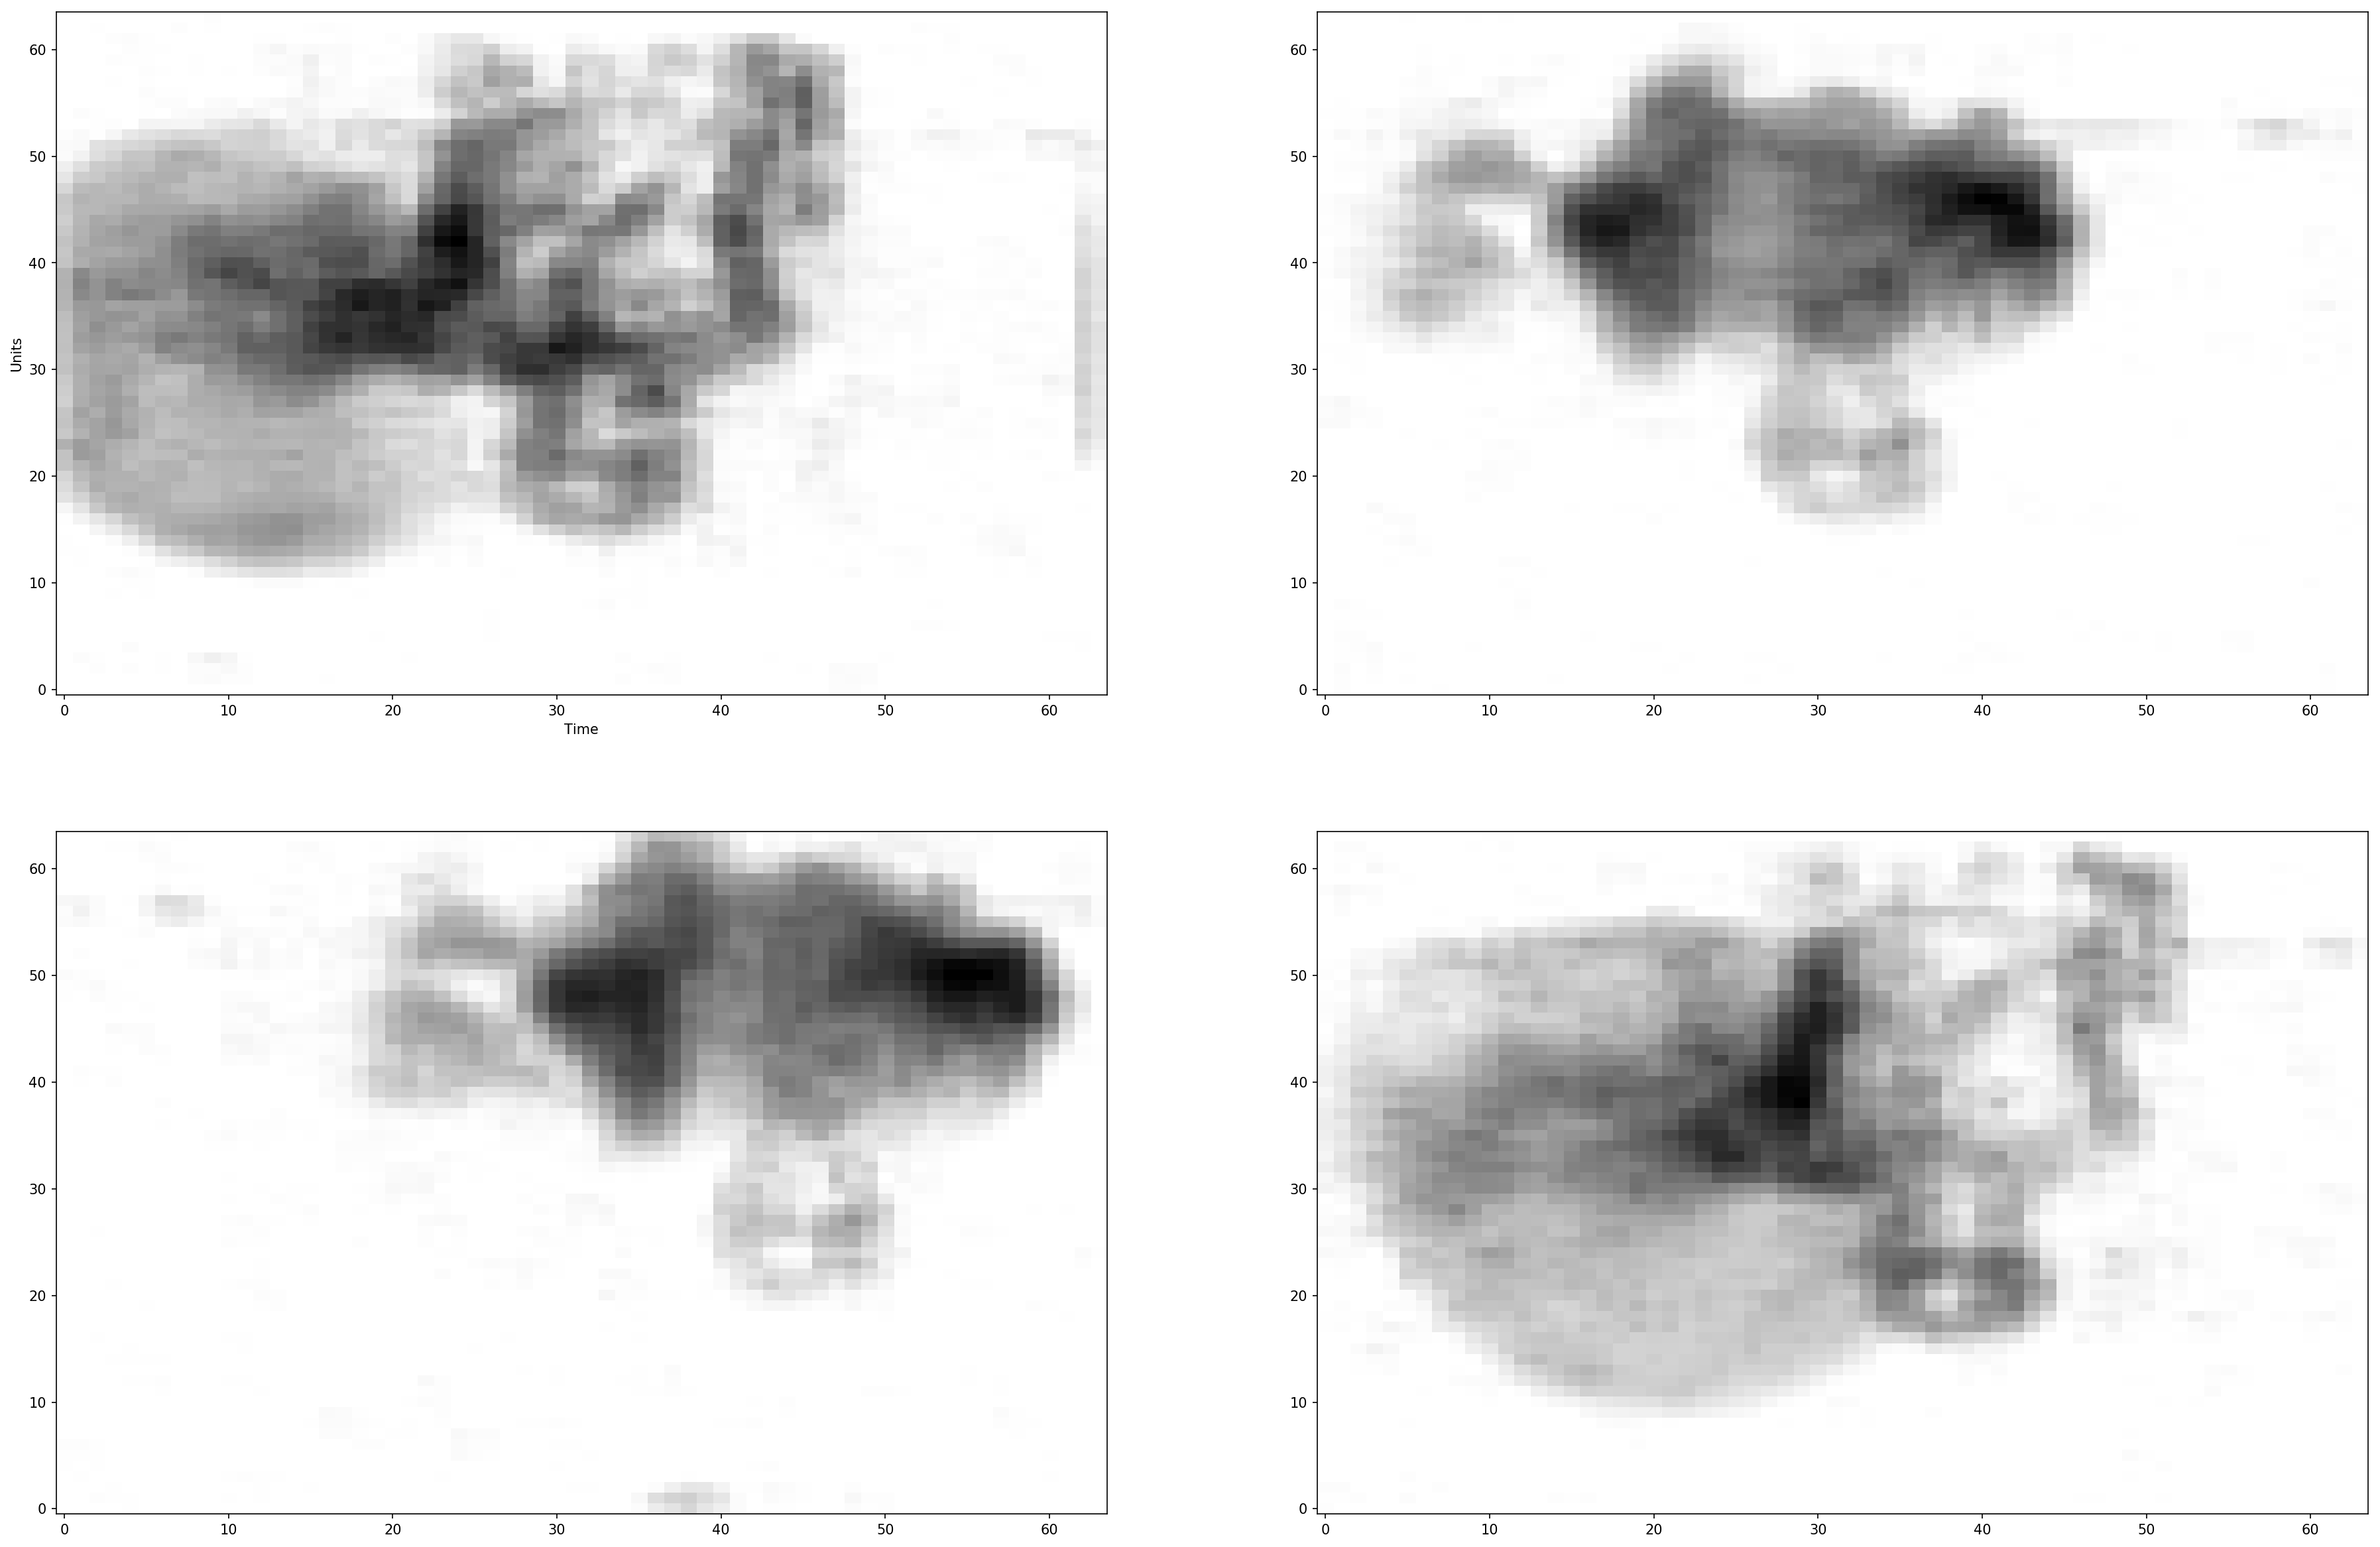

In [13]:
nb_plt = min(batch_size, 9)

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
#     print('layer', i)
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    elif isinstance(l, SpikingConv3DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1).sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [14]:
def print_progress(msg, value, width=100, a='=', b='>', c='.'):
    print('\r%s [%s%s%s] %d%%' % (msg, a*int(value*width), b, c*int((1.-value)*width), value*100), end='')

In [15]:
def train(model, params, optimizer, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    dataset_size = 0.
    for x_batch, y_batch in load_data('train'):
        dataset_size += 1.
        print('\rpre-processing dataset: %d' % dataset_size, end='')
    print('')
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= 1000*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        te.tick(nb_epochs-e)
        print('\n')
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        #with tqdm_notebook(total=len(train_dataloader)) as pb:
        e_2 = 0
        for x_batch, y_batch in load_data('train'):
            e_2 += 1
            print_progress('Epoch: %d' % e, e_2/dataset_size)
            #print('\r%d -- %d' % (e, e_2), end='')
            shp = x_batch.shape
            x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
        
        
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)

#             print('a')
            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

#             print('b')
#             for i,loss in enumerate(loss_seq[:-1]):
#                 print('  -', i)
#                 reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
#                 loss_val += reg_loss_val
#                 reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()
            
            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                #pb.update(1)
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("  |  loss=%.5f"%(mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model, 'test')
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        te.tock()
        
    return hist
        
def compute_classification_accuracy(model, trail):
    accs = []
    
    with torch.no_grad():
        #with tqdm_notebook(total=len(dataloader)) as pb:
        for x_batch, y_batch in load_data(trail):
            shp = x_batch.shape
            x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
                #pb.update(1)
    return np.mean(accs)

In [ ]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{
    'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(snn, params, optimizer, reg_loss_coef, nb_epochs=nb_epochs,
                  scheduler=scheduler, warmup_epochs=1)

test_accuracy = compute_classification_accuracy(snn, 'test')
print("Test accuracy=%.3f"%(test_accuracy))
test_accuracy = compute_classification_accuracy(snn, 'train')
print("Test accuracy=%.3f"%(test_accuracy))

pre-processing dataset: 2115


Epoch: 0 [====================================================================================================>] 100%  |  loss=2.11252
Layer 0: reg loss=nan
Layer 0: average number of spikes=0.3951


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Validation accuracy=0.232
[operation finished at 2020-02-29 16:35:11  -  took 37 minutes]
[expecting to finish at 2020-02-29 17:12:25]


Epoch: 1 [===================================================================================>................] 83%%

In [ ]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)